In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
train_dir = 'chest_xrays/train'
test_dir = 'chest_xrays/test'

In [4]:
vgg19 = VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [5]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [6]:
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20
datagen_aug = ImageDataGenerator(rescale=1./255,brightness_range=(0.5, 0.9),
                                       horizontal_flip=True,
                                       vertical_flip=False)

In [10]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = vgg19.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [11]:
def extract_train_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen_aug.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = vgg19.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [12]:
start = time.time()
train_features, train_labels = extract_train_features(train_dir, 4159)
validation_features, validation_labels = extract_features(test_dir, 624)
print("Total time to extract features:", (time.time() - start)/60)

Found 4159 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Total time to extract features: 8.429761123657226


In [13]:
# Flatten features for input into densely connected classifier
train_features = np.reshape(train_features, (4159, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (624, 4 * 4 * 512))

In [14]:
np.save('./features/train_features.npy', train_features)
np.save('./features/train_labels.npy', train_labels)
np.save('./features/validation_features.npy', validation_features)
np.save('./features/validation_labels.npy', validation_labels)

In [15]:
train_features = np.load('./features/train_features.npy')
train_labels = np.load('./features/train_labels.npy')

validation_features = np.load('./features/validation_features.npy')
validation_labels = np.load('./features/validation_labels.npy')

In [16]:
dense = models.Sequential()
dense.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
dense.add(layers.Dropout(0.5)) 
dense.add(layers.Dense(1, activation='sigmoid'))

In [17]:
dense.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy', 
              metrics=['acc'])

In [22]:
history = dense.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=[validation_features, validation_labels])

Train on 4159 samples, validate on 624 samples
Epoch 1/30
4159/4159 [==============================] - 1s 224us/sample - loss: 0.1195 - acc: 0.9562 - val_loss: 0.6474 - val_acc: 0.7612
Epoch 2/30
4159/4159 [==============================] - 1s 217us/sample - loss: 0.1138 - acc: 0.9577 - val_loss: 0.5628 - val_acc: 0.7804
Epoch 3/30
4159/4159 [==============================] - 1s 220us/sample - loss: 0.1127 - acc: 0.9591 - val_loss: 0.6430 - val_acc: 0.7692
Epoch 4/30
4159/4159 [==============================] - 1s 211us/sample - loss: 0.1124 - acc: 0.9565 - val_loss: 0.5344 - val_acc: 0.7901
Epoch 5/30
4159/4159 [==============================] - 1s 194us/sample - loss: 0.1053 - acc: 0.9613 - val_loss: 0.7775 - val_acc: 0.7452
Epoch 6/30
4159/4159 [==============================] - 1s 215us/sample - loss: 0.1075 - acc: 0.9620 - val_loss: 0.6656 - val_acc: 0.7660
Epoch 7/30
4159/4159 [==============================] - 1s 215us/sample - loss: 0.1049 - acc: 0.9608 - val_loss: 0.5756 - val

In [18]:
vgg19.trainable = True

set_trainable = False
for layer in vgg19.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [20]:
model = models.Sequential()
model.add(vgg19)
model.add(layers.Flatten())
model.add(dense)
model.add(layers.Dropout(0.5))
#model.add(dense)

In [21]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 2097665   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1)                 0         
Total params: 22,122,049
Trainable params: 11,536,897
Non-trainable params: 10,585,152
_________________________________________________________________


In [22]:
train_datagen = ImageDataGenerator(rescale=1./255,brightness_range=(0.5, 0.9),
                                       horizontal_flip=True,
                                       vertical_flip=False)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 4159 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [23]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [ ]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples//validation_generator.batch_size)

Train for 207 steps, validate for 31 steps
Epoch 1/10
 23/207 [==>...........................] - ETA: 2:31 - loss: 8.3943 - acc: 0.4500

In [35]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

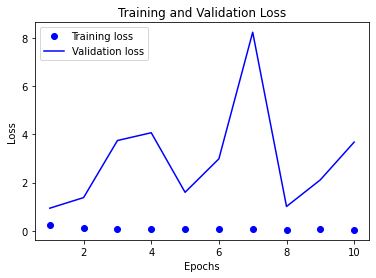

In [36]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

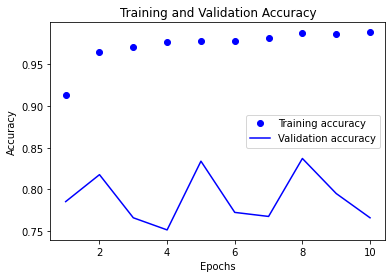

In [37]:
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()